# Generative Chatbot using RNNs (LSTM) & Attention in TensorFlow

## Purpose

The aim of this project is **to make a generative chatbot as your digital avatar.** Your speech consists of your personal voice and words. State of the art Deep Learning techniques, viz. **Sequence to Sequence modelling and Attention models** are widely used to 
1. Clone personal voice 
2. Replicate talking style and language

Voice cloning efforts such as **Samsung Bixby** which aims to preserve voice of our loved ones, or **Baidu's 'Deep Voice' AI System** addresses first half of the problem. This project focus on the latter half, i.e. to make a personified text-based chatbot, as your digital avatar.

As our aim is to make a more human-like system, we would choose to make the more powerful Generative model.


## At a glance


We have **used Recurrent Neural Networks (LSTMs),** that is the go-to architecture to solve Seq2Seq problems coupled **with Attention mechanism make a generative chatbot. The model is trained using personal chat conversations from Whatsapp and Telegram.**

**All the conversation datasets are parsed and converted to the same format to feed seq2seq model.** Both participants are marked with 2 symbols at the starting of each line. The parser code process all the files inside "DATA_DIR_PATH" folder. 

**Forward and Reverse mapping dictionaries** for Word2Index and Index2Word conversion is created. Input sequence (words) are converted to indices using  Word2Index and are padded to same length, for batch input to encoder. Output from encoder are converted from integer to words using Index2Word mapping.

To train the model, **the padded input and output sequences (indices) from the above step are fed to the S2S architecture.** The embedding layer convert words to indices, which are fed to multiple LSTM cells stacked together in hidden layers.

**Interestingly, the chat-bot is found to give responses similar in style to the personal data** used for training. Still there are a few grammatical errors, typical of generative models. But as we add more and more training data & tune the hyper-parameters to minimize the loss value, the bot behaviour is found increasingly stable.


### Datasets

I have found that training with **only real-word chat conversations between 2 humans doesn't produce stable results.** Chat messages usually contains acronyms (like 'brb', 'lol' etc), shorthand , net slang and typos to confuse neural network training. Hence, I have **used a combination of real-world chat messages and human-bot interactions to train.**

1) Personal chat **conversations from Whatsapp and Telegram** (downloaded as HTML files) {only parser included}

2) The **Human-Bot Conversational Intelligence Challenge 2 (ConvAI2) conversational dataset** conducted under the scope of NIPS (NeurIPS) 2018 Competition (JSON files)
http://convai.io/data/

3) Conversational **GuntherCox Dataset (English)** obtained from:
https://github.com/gunthercox/chatterbot-corpus/tree/master/chatterbot_corpus/data/english

4) **Human Conversations** obtained from:
https://www.kaggle.com/eibriel/rdany-conversations

## Dependencies & Initializations

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

from collections import Counter
import os
import nltk

In [2]:
alphas = 'abcdefghijklmnopqrstuvwxyz1234567890'

MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
DATA_DIR_PATH = 'data'
MAX_VOCAB_SIZE = 30000

marker_start = '<begin>'
marker_end = '<end>'
marker_unknown = '<unk>'
marker_pad = '<pad>'

# standard step - reset computation graphs
tf.reset_default_graph()

# 2 more for start and stop markers
input_seq_len = 15
output_seq_len = input_seq_len+2


In [3]:
#defines permissible characters for the chatbot
def permissible_chars(word):

    for char in word:
        if char in alphas:
            return True

    return False

In [4]:

# Compute softmax values for each sets of scores in x.
def softmax(x): 
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


## Data Parser & Conversion

To take formatted chat conversations in *.yml files inside ./DATA_DIR_PATH and convert each common words in each line indices.

In [5]:
# To parse the input yml files and create word2index and index2word mappings

target_counter = Counter()
input_counter = Counter()

input_texts = []
target_texts = []

# Parser base code of GuntherCox dataset obtained from link below and modified as per requirement.
# https://github.com/kushagra2101/ChatCrazie/blob/master/train_seq2seq.py

for file in os.listdir(DATA_DIR_PATH):
    filepath = os.path.join(DATA_DIR_PATH, file)
    if os.path.isfile(filepath):
        print('processing file: ', file)
        lines = open(filepath, 'rt', encoding='utf8').read().split('\n')
        prev_words = []
        for line in lines:

            if line.startswith('- - '):
                prev_words = []

            if line.startswith('- - ') or line.startswith('  - '):
                line = line.replace('- - ', '')
                line = line.replace('  - ', '')
                next_words = [w.lower() for w in nltk.word_tokenize(line)]
                next_words = [w for w in next_words if permissible_chars(w)]
                if len(next_words) > MAX_TARGET_SEQ_LENGTH:
                    next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]

                if len(prev_words) > 0:
                    input_texts.append(prev_words)
                    for w in prev_words:
                        input_counter[w] += 1

                    target_words = next_words[:]
                    for w in target_words:
                        target_counter[w] += 1
                    target_texts.append(target_words)

                prev_words = next_words


for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
    if idx < 20:
        print([input_words, target_words])

input_w2i, input_i2w, target_w2i, target_i2w = {},{},{},{}

### Creating Word2index and Index2word, forward and reverse mapping ###
## we will create dictionaries to provide a unique integer for each word.
input_w2i[marker_unknown] = 0
input_w2i[marker_pad] = 1
# filter out the rare words
for idx, word in enumerate(input_counter.most_common(MAX_VOCAB_SIZE)):
    input_w2i[word[0]] = idx+2

# inverse dictionary for vocab_to_int.
input_i2w = dict([(idx, word) for word, idx in input_w2i.items()])

## we will create dictionaries to provide a unique integer for each word.
target_w2i[marker_unknown] = 0
target_w2i[marker_pad] = 1
target_w2i[marker_start] = 2
target_w2i[marker_end] = 3
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_w2i[word[0]] = idx+4

# inverse dictionary for vocab_to_int.
target_i2w = dict([(idx, word) for word, idx in target_w2i.items()])


###########################################

# inputVocabLen = len(input_word2idx)
# targetVocabLen = len(target_word2idx)

###########################################

# if the word is not found then default with 0. 
# 0 in index means the word is unknown (<unk>)
x = [[input_w2i.get(word, 0) for word in sentence] for sentence in input_texts]
y = [[target_w2i.get(word, 0) for word in sentence] for sentence in target_texts]

inputVocabLen = len(input_w2i)
targetVocabLen = len(target_w2i)


processing file:  Artificial_intelligence.yml
processing file:  bot_info.yml
processing file:  computers.yml
processing file:  conversations.yml
processing file:  danny.yml
processing file:  data_intermediate.yml
processing file:  data_tolokers.yml
processing file:  data_volunteers.yml
processing file:  emotion.yml
processing file:  film.yml
processing file:  food.yml
processing file:  general convo.yml
processing file:  gentyped.txt
processing file:  GK.yml
processing file:  gossip.yml
processing file:  greetings.yml
processing file:  health.yml
processing file:  IT.yml
processing file:  jokes_fun.yml
processing file:  market_money.yml
processing file:  messages.html.txt
processing file:  messages10.html.txt
processing file:  messages100.html.txt
processing file:  messages101.html.txt
processing file:  messages102.html.txt
processing file:  messages103.html.txt
processing file:  messages104.html.txt
processing file:  messages105.html.txt
processing file:  messages106.html.txt
processi

processing file:  messages70.html.txt
processing file:  messages71.html.txt
processing file:  messages72.html.txt
processing file:  messages73.html.txt
processing file:  messages74.html.txt
processing file:  messages75.html.txt
processing file:  messages76.html.txt
processing file:  messages77.html.txt
processing file:  messages78.html.txt
processing file:  messages79.html.txt
processing file:  messages8.html.txt
processing file:  messages80.html.txt
processing file:  messages81.html.txt
processing file:  messages82.html.txt
processing file:  messages83.html.txt
processing file:  messages84.html.txt
processing file:  messages85.html.txt
processing file:  messages86.html.txt
processing file:  messages87.html.txt
processing file:  messages88.html.txt
processing file:  messages89.html.txt
processing file:  messages9.html.txt
processing file:  messages90.html.txt
processing file:  messages91.html.txt
processing file:  messages92.html.txt
processing file:  messages93.html.txt
processing fil

## Padding and Splitting

In [28]:

# Pad all the sequences to same length
for i in range(len(x)):

    if (len(x[i]) > input_seq_len):
        x[i] = x[i][:input_seq_len-1]

    # Fill in with padding marker
    for k in range(input_seq_len - len(x[i])):
        x[i] = x[i] + [input_w2i[marker_pad]]
            
    if (len(y[i]) > output_seq_len-2):
        y[i] = y[i][:output_seq_len-3]

    # Add end and begin marker
    y[i] = [target_w2i[marker_start]] + y[i] + [target_w2i[marker_end]]

    # Fill in with padding marker
    for k in range(output_seq_len - len(y[i])):
        y[i] = y[i] + [input_w2i[marker_pad]]

    if (i < 10):
        print(x[i])
        print(y[i])

        
# Train Test Split
X_train,  X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.05)

[25, 8, 1203, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 1434, 1709, 11, 37, 3482, 33, 3958, 38, 1201, 8446, 7, 8447, 4664, 3, 1]
[25, 8, 1203, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 1435, 11, 37, 2248, 33, 1201, 187, 8448, 1436, 97, 1162, 1788, 38, 3, 1]
[23, 4, 5001, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2010, 33, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1]
[23, 4, 5001, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 236, 37, 8450, 8451, 4665, 33, 37, 987, 8452, 4, 166, 102, 3, 3, 1]
[23, 4, 5001, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 295, 512, 4, 181, 10, 3959, 4, 9, 34, 10, 8453, 1344, 33, 3, 1]
[23, 4, 4302, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 26, 98, 5868, 4, 22, 35, 4, 181, 35, 50, 4667, 3, 1, 3, 1]
[23, 4, 4302, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 9, 5, 118, 4, 22, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1]
[23, 4, 4302, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 27, 302, 5, 158, 68, 32, 88, 4, 105, 5, 4, 107, 3, 3, 1]
[23, 4, 4302, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2,

## Model Helper Functions Batch feeding, Decoding & Loss

In [7]:
# Stub code sourced from Neural machine translator for English2German translation
# https://github.com/Nemzy/language-translation. Modified to suit requirements.

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = target_w2i[marker_pad], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == target_w2i[marker_pad]:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = targetVocabLen)

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(target_i2w[idx])
    return words

## Model Building

In [8]:
# Stub code sourced from Neural machine translator for English2German translation
# https://github.com/Nemzy/language-translation. Modified to suit requirements.

# Defining placeholders
# The first None means the batch size, and the batch size is unknown since user can set it. 
# The second None means the lengths of sentences. 

encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) 
                  for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) 
                  for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], 
                                 name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [targetVocabLen, size], tf.float32)
b = tf.get_variable('proj_b', [targetVocabLen], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = inputVocabLen,
                                            num_decoder_symbols = targetVocabLen,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


## Training & Plotting

step: 0, loss: 9.207267761230469
step: 500, loss: 2.911268949508667
step: 1000, loss: 2.756446123123169
step: 1500, loss: 2.0623385906219482
step: 2000, loss: 1.938844084739685
step: 2500, loss: 1.6017675399780273
step: 3000, loss: 1.72160005569458
step: 3500, loss: 1.1261392831802368
step: 4000, loss: 1.3832902908325195
step: 4500, loss: 1.2893136739730835
step: 5000, loss: 1.2555742263793945
step: 5500, loss: 1.166884183883667
step: 6000, loss: 1.1017142534255981
step: 6500, loss: 1.1417733430862427
step: 7000, loss: 1.1274404525756836
step: 7500, loss: 1.1917022466659546
step: 8000, loss: 1.0671982765197754
step: 8500, loss: 0.9028151035308838
step: 9000, loss: 0.7989295125007629
step: 9500, loss: 0.9709172248840332
step: 10000, loss: 0.9147551655769348
step: 10500, loss: 1.0661770105361938
step: 11000, loss: 0.8888979554176331
step: 11500, loss: 0.8844447135925293
step: 12000, loss: 1.0123100280761719
step: 12500, loss: 0.8911404013633728
step: 13000, loss: 0.9451074004173279
step:

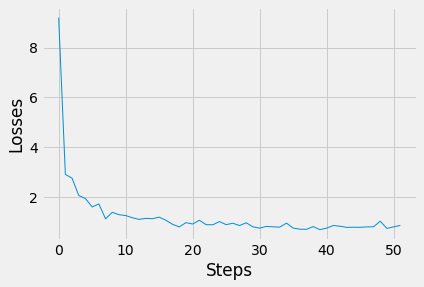

In [15]:
# Stub code sourced from Neural machine translator for English2German translation
# https://github.com/Nemzy/language-translation. Modified to suit requirements.

# ops and hyperparameters
learning_rate = 7e-3
batch_size = 96
steps = 25501

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
# tf.train.RMSPropOptimizer

# init op
init = tf.global_variables_initializer()


# Loss values appended to plot diagram
losses = []

# Save checkpoint to restore the model later 
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for step in range(steps):
        feed = feed_dict(X_train, Y_train, batch_size)
        sess.run(optimizer, feed_dict = feed)
        
        if step % 500 == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
            
    saver.save(sess, 'checkpoints/', global_step=step)
    print('Checkpoint is saved')
    
# plot the losses
with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
plt.show()

## Generate Response Prediction

In [16]:
# To predict response (inference) use the same model as defined above with forward feed

def generateReply(humanMsg):
    
    if (len(humanMsg) == 0):
        return ''
    
    with tf.Graph().as_default():
        
        replyMsg = ""

        # same format as in model building
        encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], 
                                         name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
        decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], 
                                         name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

        # output projection
        size = 512
        w_t = tf.get_variable('proj_w', [targetVocabLen, size], tf.float32)
        b = tf.get_variable('proj_b', [targetVocabLen], tf.float32)
        w = tf.transpose(w_t)
        output_projection = (w, b)

        # feed_previous is set to true so that output at time t can be fed as input at time t+1
        outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                    encoder_inputs,
                                                    decoder_inputs,
                                                    tf.contrib.rnn.BasicLSTMCell(size),
                                                    num_encoder_symbols = inputVocabLen,
                                                    num_decoder_symbols = targetVocabLen,
                                                    embedding_size = 100,
                                                    feed_previous = True,
                                                    output_projection = output_projection,
                                                    dtype = tf.float32)
        # ops for projecting outputs
        outputs_proj = [tf.matmul(outputs[i], 
                        output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

        ## Clean and Format incoming msg by humans.
        ## It is better to do the same clean/format as the data preprocessing steps
        ## for the algorithm to predict next words more accurately
        msgLowerCase = [w.lower() for w in nltk.word_tokenize(humanMsg)]
        msg = [w for w in msgLowerCase if permissible_chars(w)]
        if len(msg) > input_seq_len:
            msg = msg[0:input_seq_len-1]

        human_msg_encoded = [input_w2i.get(word, 0) for word in msg]

        # Fill in with padding marker
        for k in range(input_seq_len - len(human_msg_encoded)):
            human_msg_encoded = human_msg_encoded + [input_w2i[marker_pad]]

        # restore all variables - use the last checkpoint saved
        saver = tf.train.Saver()
        path = tf.train.latest_checkpoint('checkpoints')

        with tf.Session() as sess:
            # restore
            saver.restore(sess, path)

            # feed data into placeholders
            feed = {}
            for i in range(input_seq_len):
                feed[encoder_inputs[i].name] = np.array([human_msg_encoded[i]], dtype = np.int32)

            feed[decoder_inputs[0].name] = np.array([target_w2i[marker_start]], dtype = np.int32)

            # translate
            output_sequences = sess.run(outputs_proj, feed_dict = feed)

            ouput_seq = [output_sequences[j][0] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)

            for i in range(len(words)):
                if words[i] not in [marker_end, marker_pad, marker_start]:
                    replyMsg += words[i] + ' '
                             
        print(replyMsg)
        return replyMsg

## Chatbot Interface for Human-Bot interaction

In [ ]:
import tkinter 

def Enter_pressed(event):
    input_get = input_field.get()
    print(input_get)
    bot_reply = generateReply(input_get)
    if (len(input_get.strip()) > 0):
        messages.insert(INSERT, '\nYou says: \t%s' % input_get)
    if (len(bot_reply.strip()) > 0):
        messages.insert(INSERT, '\nBot says: \t%s' % bot_reply)
    input_user.set('')
    messages.see(tkinter.END)
    return "break"

from ttkthemes import ThemedTk
window = ThemedTk()
window.set_theme("blue")

# window = Tk()
window.geometry('300x450')
window.title("Digital Imprint of You!")

messages = Text(window)
messages.insert(INSERT, '')
messages.pack()

input_user = StringVar()
input_field = ttk.Entry(window, text=input_user)
input_field.pack(side=BOTTOM, fill=X)

# frame = Frame(window)
input_field.bind("<Return>", Enter_pressed)
input_field.pack()


btn = Button(window,text='Send', command=Enter_pressed(''))
btn.bind('<Button-1>', Enter_pressed)
btn.pack(side=RIGHT, fill=X)


window.mainloop()


hello
INFO:tensorflow:Restoring parameters from checkpoints\-25500
hi how are you 
GM
INFO:tensorflow:Restoring parameters from checkpoints\-25500
gm 
how are you?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
im good 
hows it going?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
good 
are you a robot?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
i am a human emotion of a robot 
who are you?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
im a bit of u 
wen is ur bday?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
dunno 
what are your hobbies?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
i like gaming and painting 
what do you do for living?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
i am a retired gym teacher i am 
tats better
INFO:tensorflow:Restoring parameters from checkpoints\-25500
wat temme 
how do you feel?
INFO:tensorflow:Restoring parameters from checkpoints\-25500
i am